<a href="https://colab.research.google.com/github/kimhwijin/HandsOnMachineLearing/blob/main/HOML_Exercise_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.backend as K

# 9

잡음제거 오토인코더를 사용해 이미지 분류기 훈련하기.

In [2]:
[X_train, y_train], [X_test, y_test] = keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

170508288/170498071 [==============================] - 12s 0us/step


In [11]:
encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
])

In [12]:
encoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_4 (GaussianN  (None, 32, 32, 3)        0         
 oise)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               4194816   
                                                                 
Total params: 4,195,712
Trainable params: 4,195,712
No

In [13]:
decoder = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 32, activation='relu', input_shape=[512]),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same', strides=2, activation='sigmoid')
])

In [14]:
decoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8192)              4202496   
                                                                 
 reshape (Reshape)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 3)        867       
 nspose)                                                         
                                                                 
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [15]:
denoising_ae = keras.models.Sequential([encoder, decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),metrics=["mse"])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_test, X_test))

Epoch 1/10
1563/1563 [==============================] - 270s 172ms/step - loss: 0.5939 - mse: 0.0188 - val_loss: 0.5836 - val_mse: 0.0136
Epoch 2/10
1563/1563 [==============================] - 285s 182ms/step - loss: 0.5732 - mse: 0.0102 - val_loss: 0.5769 - val_mse: 0.0111
Epoch 3/10
1563/1563 [==============================] - 291s 186ms/step - loss: 0.5684 - mse: 0.0083 - val_loss: 0.5725 - val_mse: 0.0095
Epoch 4/10
1563/1563 [==============================] - 304s 194ms/step - loss: 0.5662 - mse: 0.0075 - val_loss: 0.5702 - val_mse: 0.0086
Epoch 5/10
1563/1563 [==============================] - 301s 193ms/step - loss: 0.5650 - mse: 0.0071 - val_loss: 0.5683 - val_mse: 0.0078
Epoch 6/10
1563/1563 [==============================] - 273s 175ms/step - loss: 0.5641 - mse: 0.0067 - val_loss: 0.5671 - val_mse: 0.0073
Epoch 7/10
1563/1563 [==============================] - 294s 188ms/step - loss: 0.5634 - mse: 0.0065 - val_loss: 0.5660 - val_mse: 0.0070
Epoch 8/10
1563/1563 [============

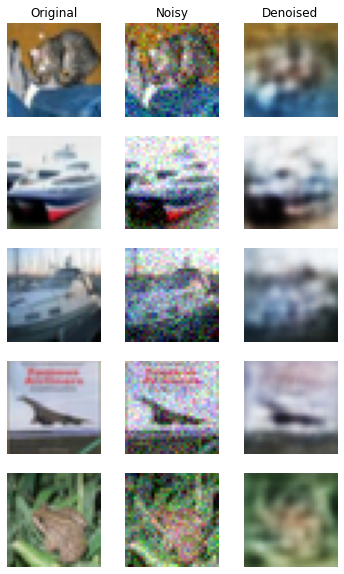

In [19]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()

In [22]:
model = keras.models.Sequential([
    encoder,
    keras.layers.Dense(10, activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10, validation_data=[X_test, y_test])

Epoch 1/10
 284/1563 [====>.........................] - ETA: 1:48 - loss: 1.8331 - accuracy: 0.3417

# 10

변이형 오토인코더를 훈련하고, 새로운 샘플을 생성해보시오.

In [ ]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var) * K.exp(log_var / 2)) + mean


In [ ]:
coding_size = 20

encoder_input = keras.layers.Input(shape=[32, 32, 3])
x = keras.layers.Conv2D(16, kernel_size=3, padding='same', strides=2, activation='relu')(encoder_input)
x = keras.layers.Conv2D(32, kernel_size=3, padding='same', strides=2, activation='relu')(x)
x = keras.layers.Conv2D(64, kernel_size=3, padding='same', strides=2, activation='relu')(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(200, activation='relu')(x)

codings_log_var = keras.layers.Dense(coding_size)(x)
codings_mean = keras.layers.Dense(coding_size)(x)

codings = Sampling()([codings_mean, codings_log_var])

v_encoder = keras.models.Model(inputs=[encoder_input], outputs=[codings_mean, codings_log_var, codings])
v_encoder.summary()

In [ ]:
decoder_input = keras.layers.Input(shape=[coding_size])

x = keras.layers.Dense(200, activation='relu')(decoder_input)
x = keras.layers.Reshape([4, 4, 64])(x)
x = keras.layers.Conv2DTranspose(32, kernel_size=3, padding='same', strides=2, activation='relu')(x)
x = keras.layers.Conv2DTranspose(16, kernel_size=3, padding='same', strides=2, activation='relu')(x)
outputs = keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same', strides=2, activation='sigmoid')(x)

v_decoder = keras.models.Model(inputs=[decoder_input], outputs=[outputs])
v_decoder.summary()

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
_,_, codings = v_encoder(encoder_input)
reconstructions = v_decoder(codings)
vae = keras.models.Model(inputs=[encoder_input], outputs=[reconstructions])

latent_loss = - 0.5 * K.sum( 1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=1)
vae.add_loss(K.mean(latent_loss) / 32.*32.*3.)

vae.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[rounded_accuracy])

In [ ]:
history = vae.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=[X_test, X_test])